(sec:q-learning)=
# Q学習

ここまでで扱った多腕バンディット問題は、取れる行動の種類が少なく、また、問題の状態が変化しない、という特徴があった。しかし、実際の問題は取れるべき行動の種類が多く (場合によっては連続変数)、また、ある時刻で取った行動により、行動を行う対象の状態が変化するのが一般的である。

このような状況において用いられる強化学習の手法にQ学習がある。Q学習のQとは行動価値関数を表すQ値のQであり、とある状態$s$ (stateのs)において取った行動$a$ (actionのa)の価値を関数として、$Q(s, a)$のように定義する。

このようなQ値を学習する方法はQ学習以外にもSARSA (state-action-reward-state-action)と呼ばれる方法もあるが、本節ではQ学習に絞って説明する。

In [1]:
"""
下準備のコード
"""

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

## Q学習の理論

Q学習では、時刻$t$における状態$s_t$と、その時に取った行動$a_t$および、その結果得られる報酬$r_t$ (rewardのr)を用いて、行動価値関数$Q$を学習していく。

この行動価値関数を考える際に満たすべき性質として、とある状態$s_t$において行動$a_t$を取った結果$s_{t+1}$という状態に遷移するとして、その後、最適な行動をとり続けたときに得られる報酬の期待値と、行動$a_t$によって直接的に得られる報酬との和を行動価値関数$Q$として採用する。

これを直接的に式として書き下すと以下のような定式化となる。

$$
Q(s_{t}, a_{t}) = R(s_{t}, a_{t}) + \gamma \max_{a'} Q(s_{t+1}, a')
$$

この式において$\gamma$は割引因子(discount factor)と呼ばれる値で、$0 < \gamma < 1$である。この式を用いて$Q(s_t, a_t)$を報酬関数$r_t = R(s_t, a_t)$だけを用いて書き下すと以下のようになることが分かる。

$$
Q(s_t, a_t) = r_t + \gamma r_{t+1} + \cdots + \gamma^n r_{t+n} + \cdots
$$

従って、各時刻$t$において得られる報酬の影響は時間の経過とともに少なくなり、$Q(s_t, a_t)$を例に取れば、この値は$r_t$の影響を最も強く受けるが、十分大きな$n$に対しては$r_{t + n}$の影響は無視して良いことが分かる。

## 倒立振子のバランシング

ここでは、単純な問題として倒立振子のバランスを取る問題について考える。倒立振子のシミュレータは[Gymnasium](https://gymnasium.farama.org/)というライブラリから簡単に使用することができる。

試しに、倒立振子のゲーム環境である`CartPole-v1`を指定し、`gym.make`関数を用いてゲーム環境`env`を作成してみる。この際、`gym.make`関数の`render_mode`パラメータに`rbg_array`を指定すると、`env.render`関数によって画面の情報をNumPyの配列として得ることができるので、Matplotlibを用いて、初期状態を描画してみる。

In [2]:
import gymnasium as gym

# ゲーム環境の作成
env = gym.make("CartPole-v1", render_mode="rgb_array")

# ゲーム環境のリセット
obsrv = env.reset(seed=31415)

# 現在の状態をRGB画像として取得する
img = env.render()

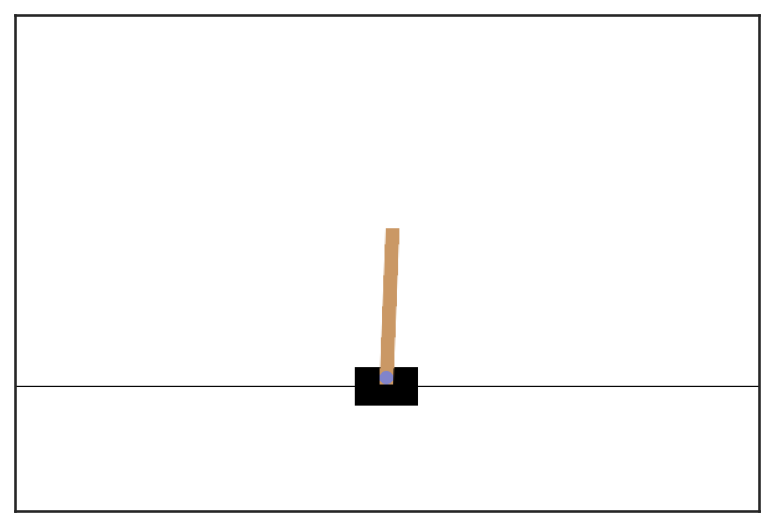

In [3]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.set(xticks=[], yticks=[])
plt.show()

すると、このような台車 (cart)の上に倒立振子 (pole)が取り付けられたものが描画される。

倒立振子は、その状態を表すいくつかのパラメータを持っており、それが`reset`関数の戻り値として取得される`obsrv`の中に格納されている。

`obsrv`は`tuple`型の変数になっていて、CartPole環境の場合には**第1要素に状態を表す変数が入っている**。

In [4]:
# 現在の状態変数を確認
print(obsrv[0])

[-3.1067048e-05 -3.8479745e-02  3.6217723e-02  3.3740070e-02]


CartPole環境の場合は、4つの浮動小数が格納されており、先頭から、
- 台車の水平位置
- 台車の速度
- 振子の角度
- 振子の角速度
をそれぞれ表している。

また、それぞれの値が取る範囲は以下のようになっている [[参考URL]](https://gymnasium.farama.org/environments/classic_control/cart_pole/)。

|Num|Observation|Min|Max|
|---|---|---|---|
| 0 | 台車の位置 | -4.8 | +4.8 |
| 1 | 台車の速度 | -Inf | +Inf |
| 2 | 振子の角度 | -24° | +24° |
| 3 | 振子の角速度 | -Inf | +Inf |

この値は、`env`の`observation_space`フィールドで確認することができる。

CartPole環境の場合には`observation_space`は`Box`という型で表されていて、`low`、`high`というフィールドにパラメータの最小値、最大値が格納されている。

In [5]:
print("Lower bound:", env.observation_space.low)
print("Upper bound:", env.observation_space.high)

Lower bound: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Upper bound: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


Gyminasiumのゲーム環境には、この他にも多数の関数が用意されており、それを強化学習に用いることができる。

まずは、その挙動を理解するために、ランダムに行動を選んだ場合にどのような動きになるのかを確認してみよう。

ランダムな行動選択には、`env.action_space.sample()`を使うことができる。CartPole環境の場合には`env.action_space.n`に格納されているとおり、取り得る行動は **0: 左に移動**, **1: 右に移動** の2つだけなので、`sample`関数はこのうちの一方をランダムに返してくる。

In [6]:
# ランダムに5回行動選択をしてみる
for i in range(5):
    print(env.action_space.sample())

0
1
0
1
0


選んだ行動をとって状態を更新するには`env.step`関数を用いる。`step`関数の引数に行動を表す整数を与えることで状態が更新される。

`step`関数もまた`reset`関数と同様に`tuple`型の変数を返してくる。ここには`reset`関数の時よりも多くの情報が含まれていて、

- **第1要素:** 現在の状態を表すパラメータ (上記の`obsrv`と同様)
- **第3要素:** 行動により直接得られた報酬
- **第4要素:** エピソードが終了したかどうか (ゲームオーバーになったかどうか)
- **第2要素:** 行動を表すパラメータが範囲外に外れたかどうか (今回は使用しない)
- **第5要素:** その他の追加情報 (今回は使用しない)

のような構成となっている。

In [7]:
obsrv, reward, done, _, _ = env.step(0)
print("Observation:", obsrv)
print("Reward:", reward)
print("Finished?:", done)

Observation: [-0.00080066 -0.23410185  0.03689252  0.3376265 ]
Reward: 1.0
Finished?: False


これらを用いてランダムに行動選択をし、その時々の状態を画像として格納する。

In [8]:
fig, ax = plt.subplots(dpi=100)
ax.set(xticks=[], yticks=[])

frames = []
f = 0
obsrv, _ = env.reset()
while True:
    f += 1
    ims = ax.imshow(env.render())
    txt = ax.text(20, 30, f"frame #{f:d}")
    frames.append([ims, txt])

    a = env.action_space.sample()
    obsrv, reward, done, _, _ = env.step(a)
    if done:
        break

plt.close()

In [9]:
import IPython.display as display
from matplotlib.animation import ArtistAnimation

# Create the animation
ani = ArtistAnimation(fig, frames, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)
plt.close()

このようにランダムに行動した場合には、途中で棒の傾きが一定以上になってしまい、エピソードが終了していることが分かる。以下では、Q学習によって行動評価関数を最適化し、より長い時間、倒立状態を保てるようにしてみよう。

この時、各変数は連続的な値を取るため、Q値のテーブルを学習するためには、値を離散化して置く必要がある。これにはNumPyのdigitize関数が使える。

In [10]:
from functools import reduce

import numpy as np

N_DIGITS = 10
N_INPUTS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

lower = env.observation_space.low
upper = env.observation_space.high
lower[1], upper[1] = -5.0, 5.0  # 速度の範囲を修正
lower[3], upper[3] = -0.5 * np.pi, 0.5 * np.pi  # 角速度の範囲を修正

bins = np.transpose(np.linspace(lower, upper, N_DIGITS))
obsrv, _ = env.reset()

In [11]:
# Q値テーブルの初期化
q_table = np.zeros((N_DIGITS**N_INPUTS, env.action_space.n))

In [12]:
# ランダムに行動する
a = env.action_space.sample()
s1 = env.step(a)

In [14]:
# 一番価値が高く見積もられている行動をとる
digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
s0 = reduce(lambda a, b: a + b * 10, digits)
a = np.argmax(q_table[s0, :])
s1 = env.step(a)

In [15]:
def softmax(x):
    x = x - np.max(x, axis=0)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [16]:
# Q学習のハイパーパラメータ
alpha = 0.5
gamma = 0.99

# Q値テーブルの初期化
q_table = np.zeros((N_DIGITS**N_INPUTS, env.action_space.n))

for epi in tqdm(range(10000)):
    # ゲーム環境のリセット
    obsrv, _ = env.reset()

    # エピソード開始
    while True:
        # 現在の状態に対応する行番号を計算
        digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
        s0 = reduce(lambda a, b: a + b * 10, digits)

        # ε-greedy法による行動選択
        # if np.random.random() < 0.5:
        #     a = env.action_space.sample()
        # else:
        #     a = np.argmax(q_table[s0, :])

        # softmax探索による行動選択
        prob = softmax(q_table[s0, :])
        a = np.random.choice(np.arange(len(prob)), p=prob)

        # 状態の更新
        obsrv, reward, done, _, info = env.step(a)

        # 新たな状態に対する行番号を計算
        digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
        s1 = reduce(lambda a, b: a + b * 10, digits)

        # Qテーブルの更新
        q0 = q_table[s0, a]
        best_q1 = np.max(q_table[s1, :])
        q_table[s0, a] = (1.0 - alpha) * q0 + alpha * (reward + gamma * best_q1)

        if done:
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
fig, ax = plt.subplots(dpi=100)
ax.set(xticks=[], yticks=[])

frames = []
f = 0
obsrv, _ = env.reset()
while True:
    f += 1
    ims = ax.imshow(env.render())
    txt = ax.text(20, 30, f"frame #{f:d}")
    frames.append([ims, txt])

    digits = [np.digitize(x, bin) for x, bin in zip(obsrv, bins)]
    s0 = reduce(lambda a, b: a + b * 10, digits)
    a = np.argmax(q_table[s0, :])

    obsrv, reward, done, _, _ = env.step(a)
    if done:
        break

plt.close()

In [18]:
import IPython.display as display
from matplotlib.animation import ArtistAnimation

# Create the animation
ani = ArtistAnimation(fig, frames, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)
plt.close()